In [1]:
import torch
import numpy as np
import os, sys, glob
import matplotlib.pyplot as plt
import PIL.Image as Image
sys.path.insert(0, "/home/cfoley_waller/defocam/SpectralDefocusCam")
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

import train
import utils.helper_functions as helper
import utils.diffuser_utils as diffuser_utils

%load_ext autoreload
%autoreload 2

### Define the relevant paths to weights, data and parameters
By defining these paths, the notebook should be able to transition easily between data + model pairings.

In [2]:
config_path = "/home/cfoley_waller/defocam/SpectralDefocusCam/config_files/training/train_11_4_2023_lri_precomputed_stack3.yml"
exp_meas_path = "/home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/10_26/measurements/exp_meas_ducksmallfront_ONAXIS_telecent25um_10_26"
trained_weights_path = "/home/cfoley_waller/defocam/defocuscamdata/models/checkpoint_train_11_4_2023_lri_precomputed_stack3.yml/2023_11_05_04_01_06/saved_model_ep294_testloss_0.022588131621617963.pt"

### Load experimental data
Let's load in our experimental data for inference.

In [3]:
#First we load our config
config = helper.read_config(config_path)
num_ims = config["forward_model_params"]["stack_depth"]
device = torch.device(config["device"])
print(torch.cuda.get_device_name(device))


NVIDIA GeForce RTX 3090


In [4]:
def preprocess_exp_meas(meas, config):
    # read
    center = config["image_center"]
    dim = config["patch_crop"][0]
    crop = lambda x: x[center[0] -dim//2:center[0]+dim//2, center[1]-dim//2: center[1]+dim//2]
    meas =  crop(np.array(Image.open(meas), dtype=float))

    # downsample
    meas = diffuser_utils.pyramid_down(meas, config["patch_size"])

    #one-normalize
    meas = (meas - np.min(meas))/(np.max(meas - np.min(meas)))
    return meas

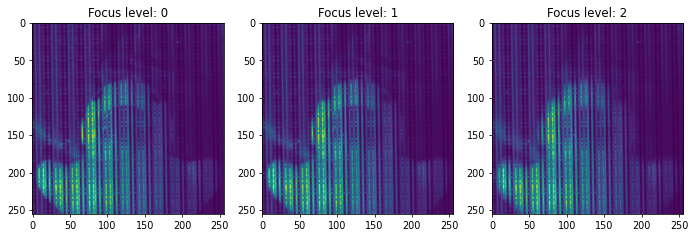

In [5]:
exp_meas = [preprocess_exp_meas(m, config) for m in sorted(glob.glob(os.path.join(exp_meas_path, "*.bmp")))][:num_ims]

fig, ax = plt.subplots(1, len(exp_meas), figsize = (4*len(exp_meas), 4))
fig.set_dpi(70)
for i,meas in enumerate(exp_meas):
    ax[i].imshow(exp_meas[i])
    ax[i].set_title(f"Focus level: {i}")
plt.show()

### Build model
First we need to initialize the model and load our weights. We note that the simulation model has performed the adjoint to generate training data, while our experimental data has not, so we need to change some of the model params.

**Note**: This may take a while, as the model needs to load some very large psf calibration data.

In [6]:
config["data_precomputed"] = False
config["forward_model_params"]["operations"]["sim_meas"] = False
config["preload_weights"] = True
config["checkpoint_dir"] = trained_weights_path

model = train.get_model(config=config, device=device)
model.eval()
print(f"Model using: {torch.cuda.get_device_name(device)}")


Model using: NVIDIA GeForce RTX 3090


### Run inference
We can now run inference on our data by passing it through the model. It's that simple!

In [7]:
data_stack = torch.stack([torch.tensor(e, device=device) for e in exp_meas], dim=0)
data_stack = torch.unsqueeze(torch.unsqueeze(data_stack, 1),0)
exp_meas_adj = model.model1(data_stack)

#Normalize between models to keep consistency with dataloading
exp_meas_adj = ((exp_meas_adj - exp_meas_adj.mean()) / exp_meas_adj.std()).float()

prediction = model.model2(exp_meas_adj)

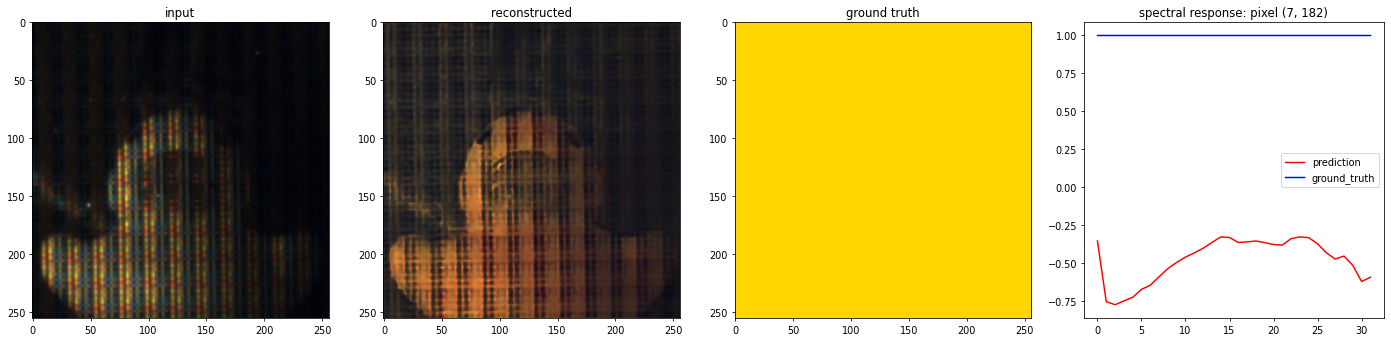

In [9]:
em_np, pred_np = exp_meas_adj.detach().cpu().numpy(), prediction.detach().cpu().numpy()
fig = train.generate_plot(em_np, pred_np, np.ones_like(pred_np), config["false_color_mat_path"])
plt.show()